In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

In [2]:
def get_dataset_size(ds):
    """Calculate the size of the dataset in memory. Code generated by AI."""
    size_bytes = ds.nbytes
    size_mb = size_bytes / (1024 * 1024)
    size_gb = size_mb / 1024
    return size_bytes, size_mb, size_gb

In [3]:
import geopandas as gpd
import numpy as np
import xarray as xr
from shapely.geometry import Point


def create_random_data_within_polygon(
    shapefile_path, grid_resolution=60, target_crs="EPSG:26915"
):
    """
    Creates an xarray dataset with random float data within a polygon from a shapefile.
    Reprojects the shapefile to EPSG:26915 if necessary and avoids loops for speed optimization.
    Code generated by AI.

    Parameters:
    - shapefile_path (str): Path to the shapefile containing the polygon.
    - grid_resolution (int, optional): Grid resolution in meters (default is 60m).
    - target_crs (str, optional): The target CRS for the operation (default is EPSG:26915).

    Returns:
    - xarray.Dataset: The dataset with random values inside the polygon and NaNs outside.
    """

    # Step 1: Read the shapefile and check its CRS
    gdf = gpd.read_file(shapefile_path)

    # Reproject to target CRS if necessary
    if gdf.crs != target_crs:
        gdf = gdf.to_crs(target_crs)

    polygon = gdf.geometry[0]  # Assuming the shapefile contains one polygon

    # Step 2: Define grid boundaries and resolution
    minx, miny, maxx, maxy = polygon.bounds
    num_rows = int((maxy - miny) / grid_resolution)
    num_cols = int((maxx - minx) / grid_resolution)

    # Generate x and y coordinates based on grid resolution
    x_coords = np.linspace(minx, maxx, num_cols)
    y_coords = np.linspace(miny, maxy, num_rows)

    # Step 3: Create a grid mesh using numpy
    xx, yy = np.meshgrid(x_coords, y_coords)

    # Step 4: Vectorize the point creation and polygon containment check
    points = np.array([Point(x, y) for x, y in zip(xx.ravel(), yy.ravel())])
    mask = np.array([polygon.contains(point) for point in points]).reshape(
        num_rows, num_cols
    )

    # Step 5: Create a data array and fill with random values inside the polygon, NaN outside
    data = np.full((num_rows, num_cols), np.nan)
    data[mask] = np.random.random(mask.sum())  # Assign random floats inside the polygon

    # Step 6: Create an xarray dataset
    ds = xr.Dataset(
        {"random_data": (["y", "x"], data)},
        coords={"x": x_coords, "y": y_coords},
        attrs={"crs": target_crs},  # Storing CRS in the dataset attributes
    )

    return ds

In [4]:
ds = create_random_data_within_polygon(
    shapefile_path="/Users/dillonragar/Library/CloudStorage/OneDrive-LynkerTechnologies/2024 CPRA Atchafalaya DSS/data/Atchafalaya MP Boundary/Atchafalaya MP Boundary.shp",
    grid_resolution=100,
)

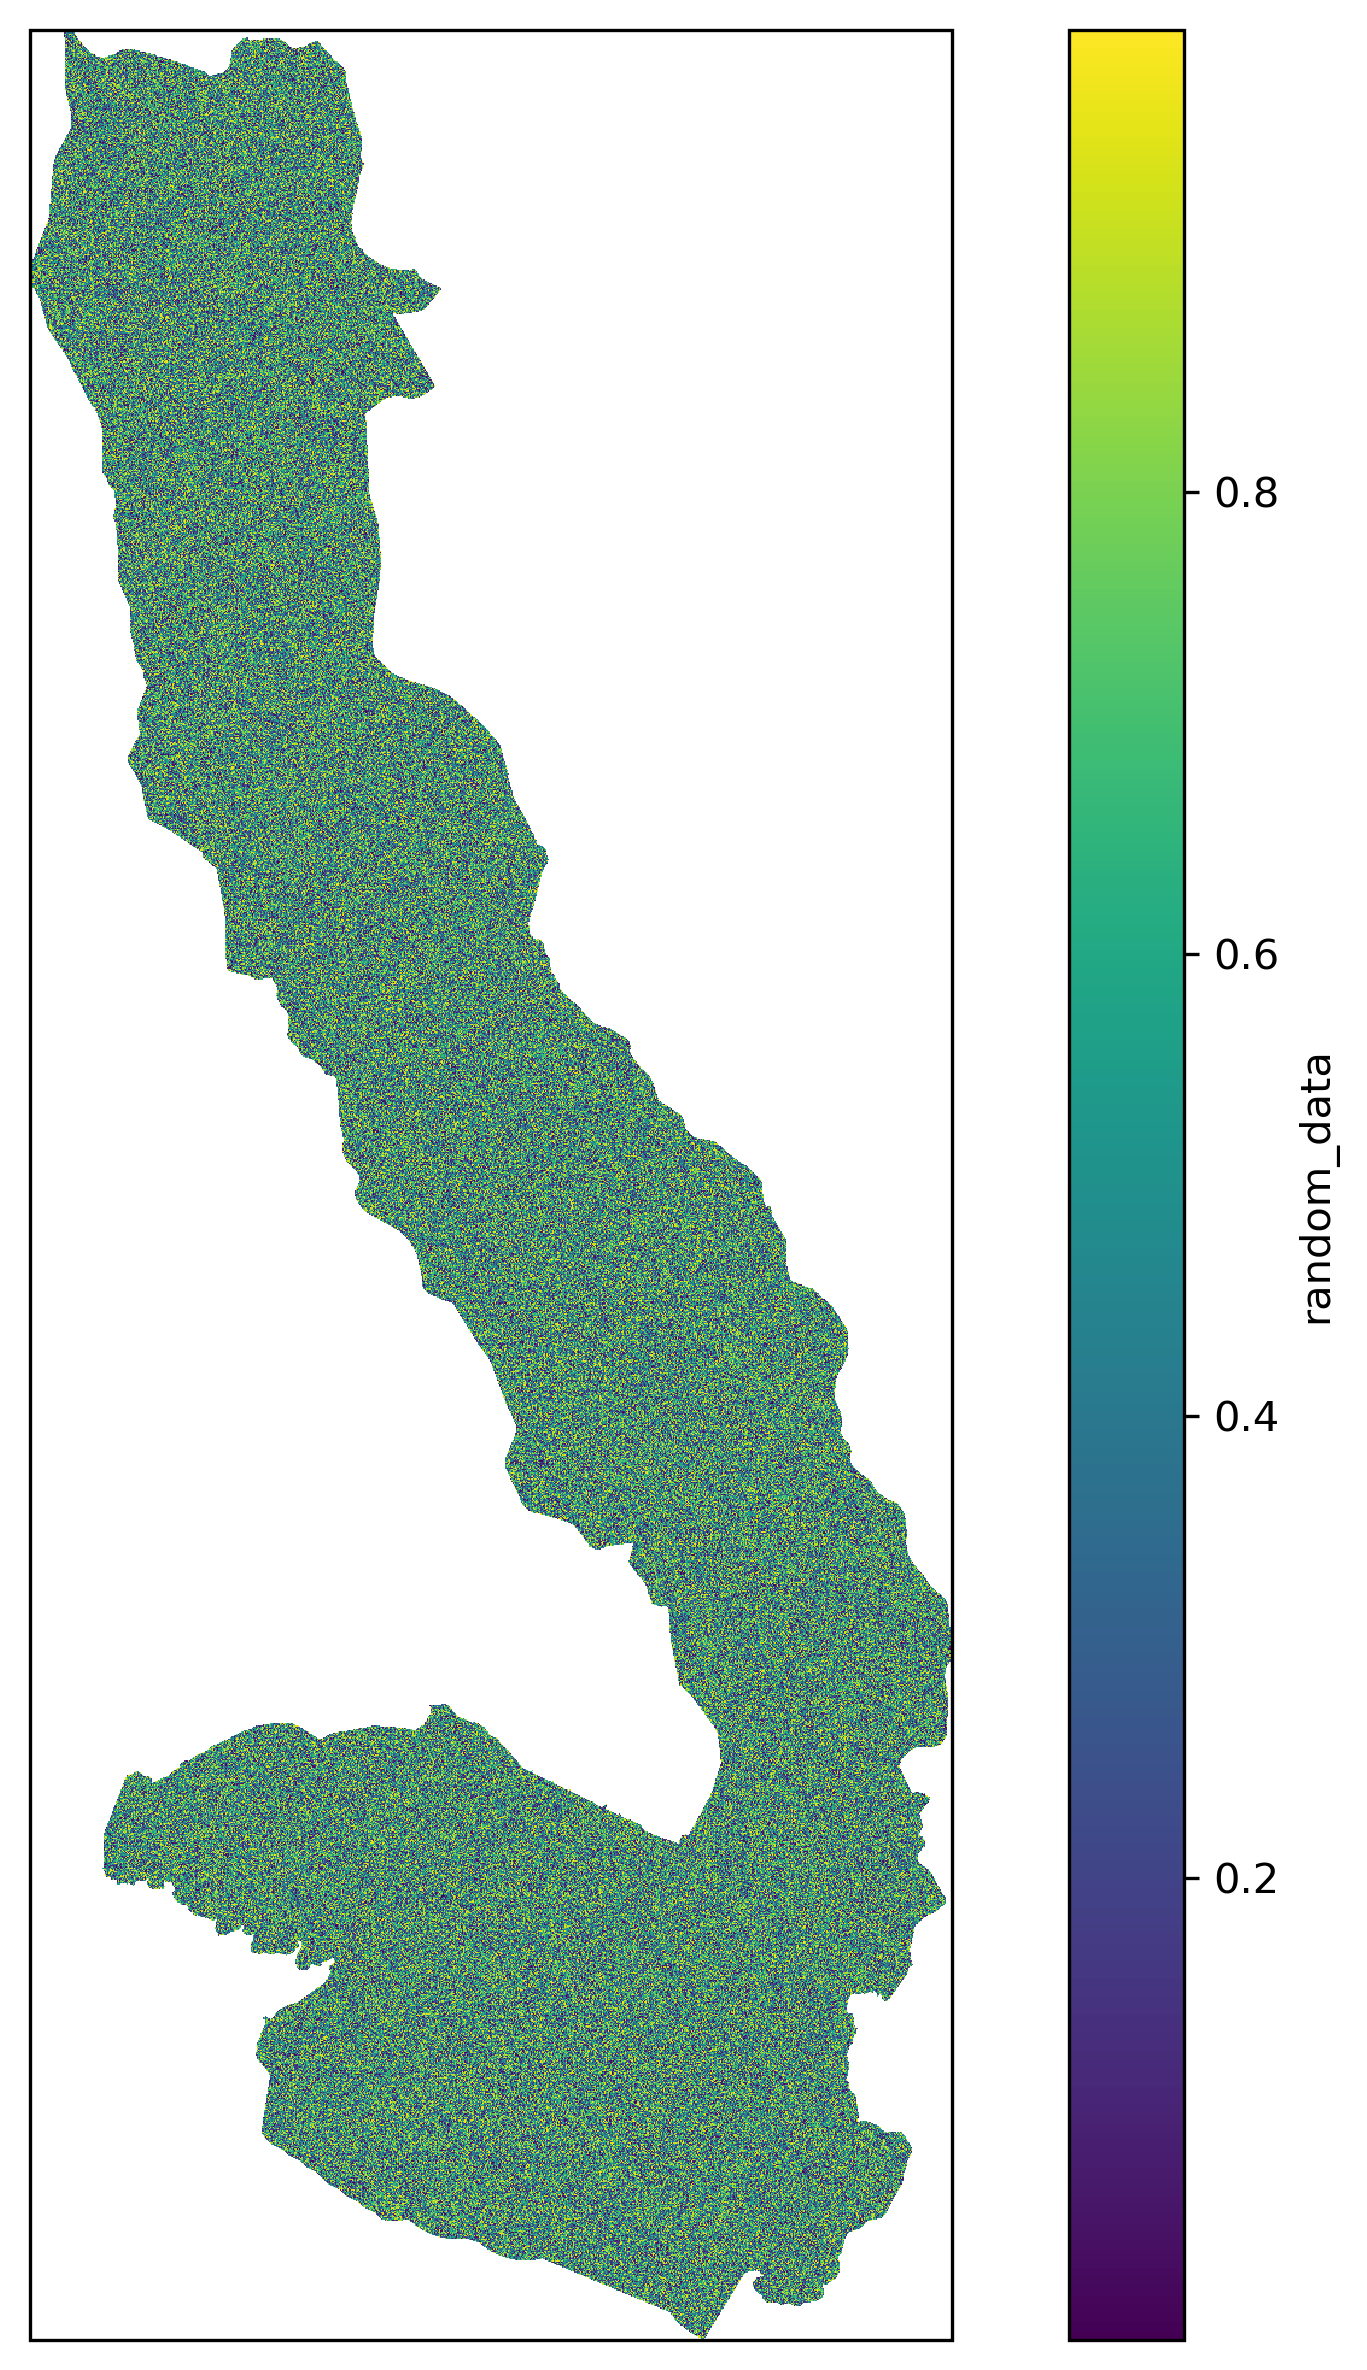

In [5]:
crs = ccrs.UTM("15")
# Defining the figure
fig = plt.figure(figsize=(10, 10), facecolor="w", edgecolor="k", dpi=300)
# Axes with Cartopy projection
ax = plt.axes(projection=crs)
ds["random_data"].plot.imshow(ax=ax, transform=crs)
plt.show()

In [6]:
size_bytes, size_mb, size_gb = get_dataset_size(ds)
print(f"\nDataset size in memory:")
print(f"  {size_bytes:,} bytes")
print(f"  {size_mb:.2f} MB")
print(f"  {size_gb:.2f} GB")


Dataset size in memory:
  11,753,496 bytes
  11.21 MB
  0.01 GB


In [7]:
def duplicate_random_data_with_new_values(ds, n):
    """
    Duplicates the 'random_data' layer n times with new random values for each variable.
    Calculates the total size of the dataset with the added variables in gigabytes.
    Code generated by AI.

    Parameters:
    - ds (xarray.Dataset): The input dataset containing the 'random_data' variable.
    - n (int): The number of times to duplicate the 'random_data' variable, each with new random values.

    Returns:
    - xarray.Dataset: The dataset with n new variables, each containing different random values.
    - float: The size of the dataset in gigabytes (GB).
    """

    # Step 1: Get the mask where data is not NaN (inside the polygon)
    mask = ~np.isnan(ds["random_data"].values)

    # Step 2: Duplicate the random_data layer n times with different random values
    for i in range(n):
        # Create a new array filled with NaNs
        new_data = np.full(ds["random_data"].shape, np.nan)

        # Generate new random values for the points inside the polygon (masked region)
        new_data[mask] = np.random.random(mask.sum())

        # Add the new data as a new variable in the dataset
        ds[f"random_data_{i+1}"] = (("y", "x"), new_data)

    # Step 3: Calculate the size of the dataset in bytes
    dataset_size_bytes = ds.nbytes

    # Step 4: Convert size from bytes to gigabytes
    dataset_size_gb = dataset_size_bytes / (1024**3)

    return ds, dataset_size_gb


# Example usage:

# Assume ds is the dataset generated from the create_random_data_within_polygon function
# ds, size_gb = duplicate_random_data_with_new_values(ds, 10)  # Duplicate 10 times with new random data
# print(f"Dataset size with 10 new random layers: {size_gb:.4f} GB")

In [8]:
full_ds, size = duplicate_random_data_with_new_values(ds, 60)

In [9]:
full_ds

<xarray.Dataset> Size: 716MB
Dimensions:         (y: 1917, x: 765)
Coordinates:
  * x               (x) float64 6kB 6.003e+05 6.004e+05 ... 6.767e+05 6.768e+05
  * y               (y) float64 15kB 3.24e+06 3.24e+06 ... 3.432e+06 3.432e+06
Data variables: (12/61)
    random_data     (y, x) float64 12MB nan nan nan nan nan ... nan nan nan nan
    random_data_1   (y, x) float64 12MB nan nan nan nan nan ... nan nan nan nan
    random_data_2   (y, x) float64 12MB nan nan nan nan nan ... nan nan nan nan
    random_data_3   (y, x) float64 12MB nan nan nan nan nan ... nan nan nan nan
    random_data_4   (y, x) float64 12MB nan nan nan nan nan ... nan nan nan nan
    random_data_5   (y, x) float64 12MB nan nan nan nan nan ... nan nan nan nan
    ...              ...
    random_data_55  (y, x) float64 12MB nan nan nan nan nan ... nan nan nan nan
    random_data_56  (y, x) float64 12MB nan nan nan nan nan ... nan nan nan nan
    random_data_57  (y, x) float64 12MB nan nan nan nan nan ... nan nan nan nan
    random_data_58  (y, x) float64 12MB nan nan nan nan nan ... nan nan nan nan
    random_data_59  (y, x) float64 12MB nan nan nan nan nan ... nan nan nan nan
    random_data_60  (y, x) float64 12MB nan nan nan nan nan ... nan nan nan nan
Attributes:
    crs:      EPSG:26915

In [10]:
# serialized to NetCDF size is 1.99 GB.
# full_ds.to_netcdf("./test_full.nc")

In [11]:
size_bytes, size_mb, size_gb = get_dataset_size(full_ds)
print(f"\nDataset size in memory:")
print(f"  {size_bytes:,} bytes")
print(f"  {size_mb:.2f} MB")
print(f"  {size_gb:.2f} GB")


Dataset size in memory:
  715,675,896 bytes
  682.52 MB
  0.67 GB


In [12]:
def generate_xarray_dataset(nx=1275, ny=3196, num_vars=60):
    """test netcdf memory requirements. Code generated by AI.

    simple method: does not take into account NaN values outside of WPUs"""
    # Create coordinates
    x = np.arange(nx)
    y = np.arange(ny)

    # Initialize an empty dictionary to store variables
    data_vars = {}

    # Generate data for each variable
    for i in range(num_vars):
        var_name = f"var_{i+1:02d}"
        data = np.random.rand(ny, nx)  # Random data with shape (y, x)
        data_vars[var_name] = xr.DataArray(data, dims=["y", "x"])

    # Create the dataset
    ds = xr.Dataset(data_vars=data_vars, coords={"x": x, "y": y})

    return ds


# Generate the dataset
dataset = generate_xarray_dataset()

# Print basic information about the dataset
print(dataset)

# Optionally, you can save the dataset to a netCDF file
# dataset.to_netcdf('my_dataset.nc')

<xarray.Dataset> Size: 2GB
Dimensions:  (x: 1275, y: 3196)
Coordinates:
  * x        (x) int64 10kB 0 1 2 3 4 5 6 ... 1268 1269 1270 1271 1272 1273 1274
  * y        (y) int64 26kB 0 1 2 3 4 5 6 ... 3189 3190 3191 3192 3193 3194 3195
Data variables: (12/60)
    var_01   (y, x) float64 33MB 0.9805 0.8555 0.2499 ... 0.9729 0.3098 0.04882
    var_02   (y, x) float64 33MB 0.4394 0.1506 0.1488 ... 0.1794 0.5313 0.4227
    var_03   (y, x) float64 33MB 0.9672 0.64 0.5902 ... 0.6543 0.156 0.8824
    var_04   (y, x) float64 33MB 0.2402 0.5382 0.9561 ... 0.6333 0.6248 0.6572
    var_05   (y, x) float64 33MB 0.7609 0.0923 0.2943 ... 0.74 0.4407 0.9471
    var_06   (y, x) float64 33MB 0.8497 0.4305 0.7078 ... 0.3338 0.9813 0.6245
    ...       ...
    var_55   (y, x) float64 33MB 0.4639 0.3171 0.4593 ... 0.9063 0.7035 0.2704
    var_56   (y, x) float64 33MB 0.2187 0.6656 0.4212 ... 0.02751 0.1691 0.5496
    var_57   (y, x) float64 33MB 0.1578 0.4753 0.316 ... 0.7668 0.4368 0.5239
    var_58   (y, 

In [13]:
size_bytes, size_mb, size_gb = get_dataset_size(dataset)
print(f"\nDataset size in memory:")
print(f"  {size_bytes:,} bytes")
print(f"  {size_mb:.2f} MB")
print(f"  {size_gb:.2f} GB")


Dataset size in memory:
  1,955,987,768 bytes
  1865.38 MB
  1.82 GB
